In [1]:
# imports
import torch
import json
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# figure aesthetics
# plt.style.use(['dark_background','seaborn-notebook'])  # for dark themes
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])
# plt.style.use(['seaborn-notebook'])

In [3]:
root = Path('..')

# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
# print(f"{sys.executable = }")

# from utils import spaths, dmaps
import sf_nets.models as models
import sf_nets.datasets as datasets
from utils.mpl_utils import coord_grid

# Dataset

In [4]:
name_ds = 'Parab3'

In [5]:
dataset = getattr(datasets, name_ds)
data_path = root / 'data' / name_ds
model_path = root / 'results' / 'models' / name_ds.lower()

## Path

In [6]:
times, path = torch.load(data_path / 'raw' / 'path.pt')
len(path)

66668

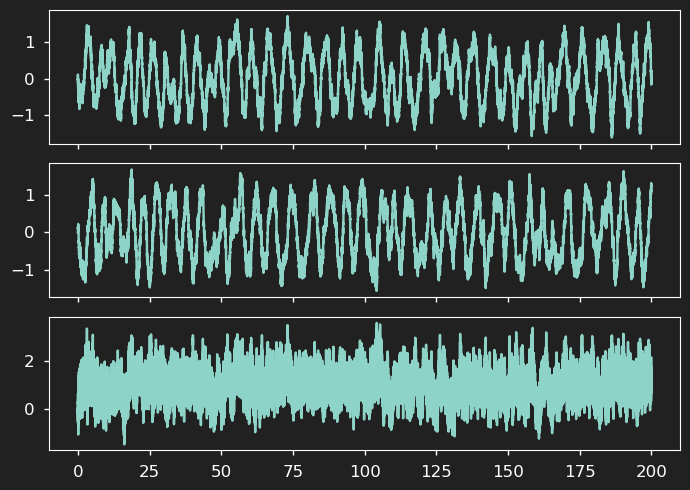

In [7]:
fig, axs = plt.subplots(nrows=len(path.T), sharex=True)
for p, ax in zip(path.T, axs):
    ax.plot(times, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [8]:
colors = ['#8dd3c7', '#feffb3', '#fa8174']
cmap1 = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

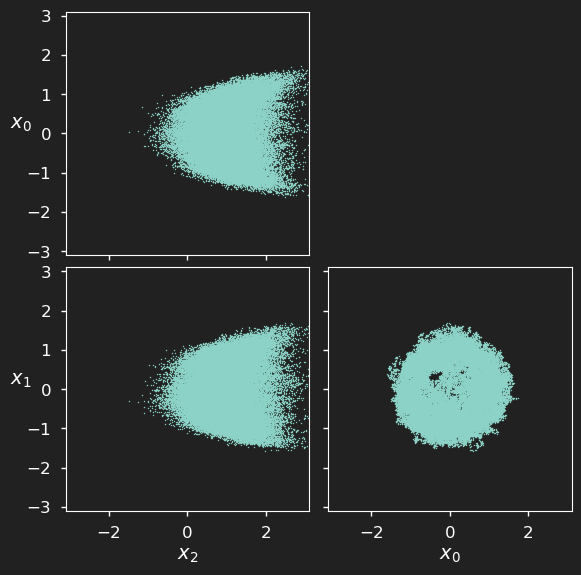

In [10]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, path, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

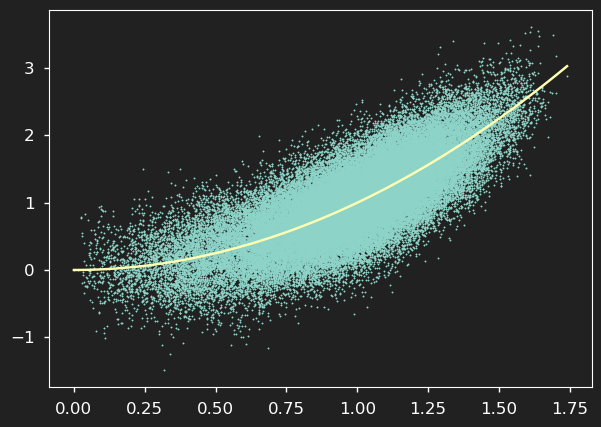

In [72]:
x, y, z = path.T
r = np.sqrt(x**2 + y**2)

plt.scatter(r, z, s=1)

r_max = np.max(r)
r_lin = np.linspace(0, r_max, 100)
plt.plot(r_lin, r_lin**2, c='C1')

plt.show()

# Training dataset

In [12]:
train_ds = dataset(root / 'data')
train_data = train_ds.data.numpy()

In [13]:
np.any(train_ds == np.nan)

False

In [48]:
len(train_ds)

2978

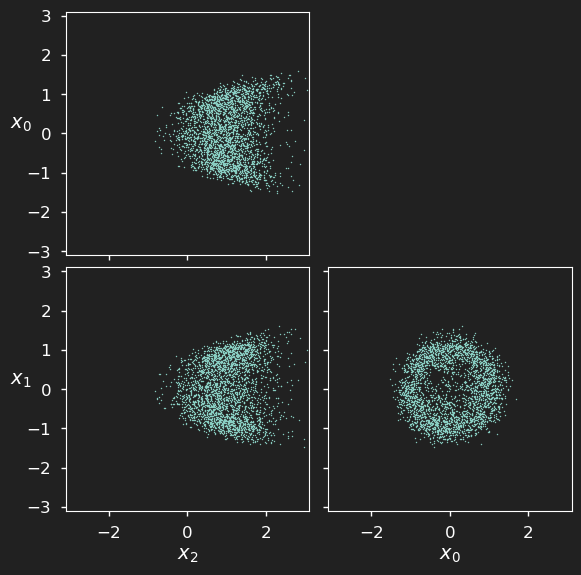

In [16]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, train_data, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

## Timescale separation

In [17]:
covis = np.array([covi.detach().numpy() for dp, covi, proj in train_ds])
covis.shape

(2978, 3, 3)

In [19]:
data_evals, data_evecs = zip(*[np.linalg.eigh(covi) for covi in covis])  # zip(*...) is equiv to transposing :)
data_evals, data_evecs = np.array(data_evals), np.array(data_evecs)

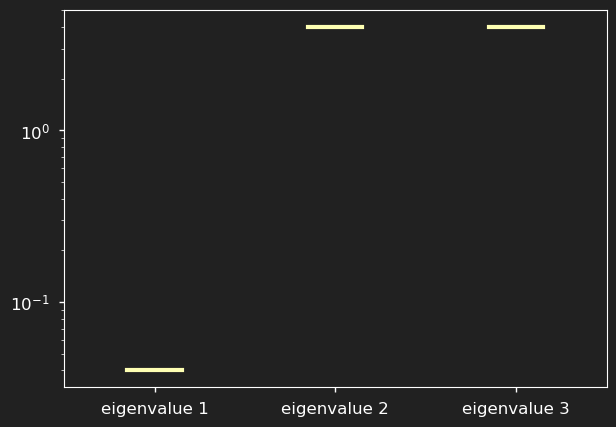

In [20]:
plt.boxplot(data_evals,
            labels=[f"eigenvalue {n+1}" for n in range(data_evals.shape[1])],
            medianprops={'lw': 3})
plt.yscale('log');

## Projection

In [21]:
slow_proj = train_ds.slow_proj
slow_proj.size()

torch.Size([2978, 3])

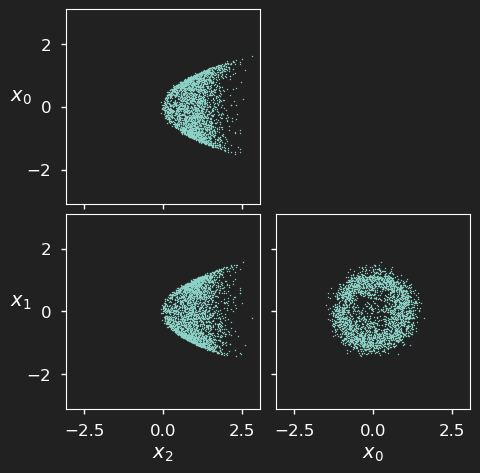

In [23]:
fig = plt.figure(figsize=(8,8))

gs = coord_grid(fig, slow_proj, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

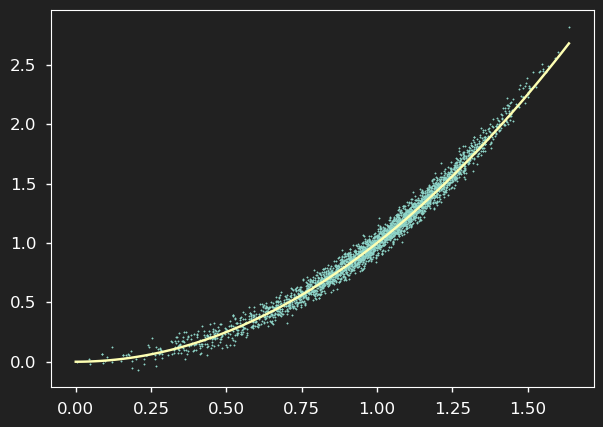

In [27]:
x, y, z = slow_proj.T
r = np.sqrt(x**2 + y**2)

plt.scatter(r, z, s=1);

r_max = torch.max(r)
r_lin = np.linspace(0, r_max, 100)
plt.plot(r_lin, r_lin**2, c='C1');

# Models

In [256]:
model_id = 'mahl1_elu_1_r1'
model_data = torch.load(f'../results/models/{name_ds}/{model_id}.pt')

In [257]:
model = models.MahalanobisAutoencoder(**model_data['info']['arguments'])
model_dict = 'model_dict'
model.eval()

MahalanobisAutoencoder(
  (encoder): Sequential(
    (layer1): Linear(in_features=3, out_features=4, bias=True)
    (activation1): ELU(alpha=1.0)
    (layer2): Linear(in_features=4, out_features=4, bias=True)
    (activation2): ELU(alpha=1.0)
    (layer3): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (layer1): Linear(in_features=2, out_features=4, bias=True)
    (activation1): ELU(alpha=1.0)
    (layer2): Linear(in_features=4, out_features=4, bias=True)
    (activation2): ELU(alpha=1.0)
    (layer3): Linear(in_features=4, out_features=3, bias=True)
  )
  (mah_loss): MahalanobisLoss()
  (proj_loss): L1Loss()
)

### Training history

In [258]:
train_losses = model_data['history']['train_losses']
valid_losses = model_data['history']['valid_losses']
checkpoints = model_data['history']['checkpoints']
epochs = range(1, model_data['info']['config']['max_epochs']+1)
best_epoch = model_data['best']['epoch']

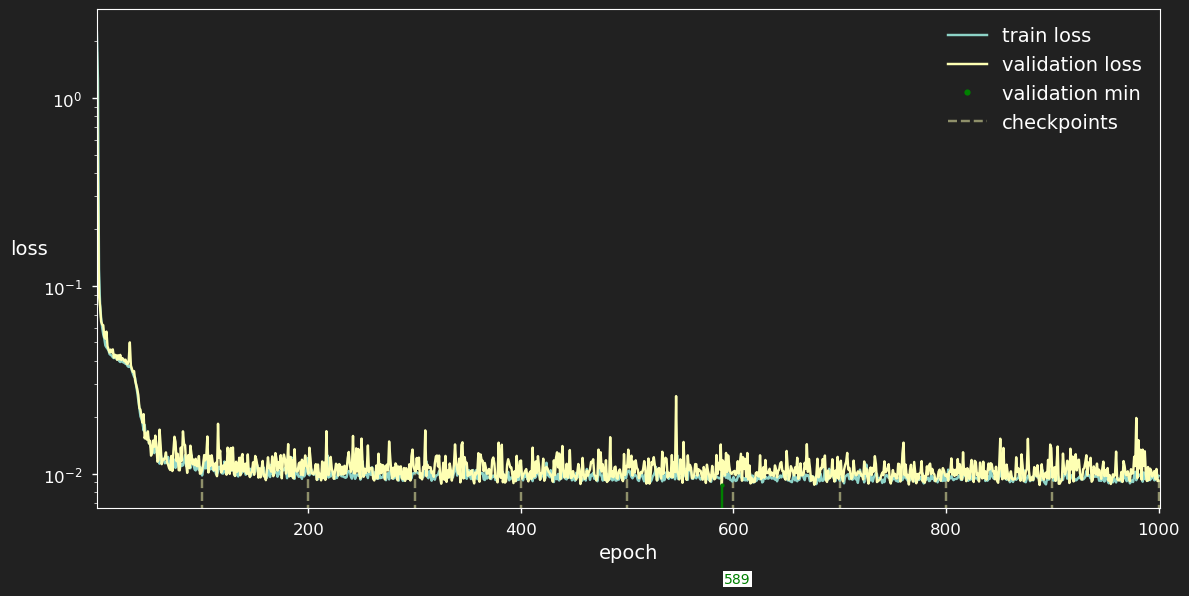

In [259]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
loss_color = loss_line.get_color()

# regular checkpoints
check_ids = [check_id for check_id, check_type in checkpoints if check_type != 'best']
check_loss = [valid_losses[idx-1] for idx in check_ids]
plt.vlines(x=check_ids, ymin=0, ymax=check_loss, ls='--', color=loss_color, alpha=0.5, label='checkpoints')

# smallest validation loss / "best" model
smallest_loss = valid_losses[best_epoch-1]
plt.vlines(x=best_epoch, ymin=0, ymax=smallest_loss, color='g')
ax.plot(best_epoch, smallest_loss, 'o', color='g', label='validation min', markersize=3)

ax.text(best_epoch+2, .3*smallest_loss, f'{best_epoch}', rotation=0, color='g', bbox={'fc': 'w', 'ec':'None', 'boxstyle':'Square, pad=0.1'})

ax.set_xlim([epochs[0], epochs[-1]+1])
# ax.set_ylim([0.0, train_losses[1]])
ax.set_xticks(check_ids[1::2])
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)

ax.set_yscale('log')
ax.legend()

fig.tight_layout()
# fig.savefig(root / f"results/figs/{name_ds}/{model_id}_loss.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

In [260]:
insp_epoch = 'best'

In [261]:
if insp_epoch == 'best':
    state_dict = model_data['best']['model_dict']
    insp_epoch = model_data['best']['epoch']
else:
    check_dict = torch.load(f'../results/models/{name_ds}/{model_id}/state_at_{insp_epoch}.pt')
    state_dict = remove_mask(check_dict['model_dict'])

In [262]:
model.load_state_dict(state_dict)
model.eval();

## Reconstruction visualization

In [263]:
test_ds = dataset(root / 'data', train=False)
len(test_ds)

1467

In [264]:
test_data = test_ds.data
test_slow = test_ds.slow_proj
# test_data_np = test_data.detach().numpy()

In [265]:
with torch.no_grad():
    test_rec = model(test_data)
# test_rec_np = test_rec.detach().numpy()

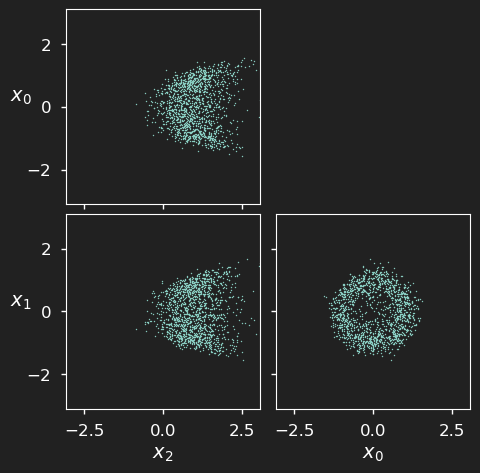

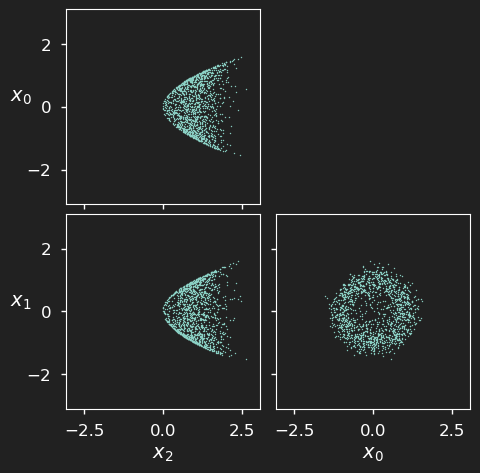

In [266]:
fig = plt.figure(figsize=(8,8))
gs = coord_grid(fig, test_data, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

fig = plt.figure(figsize=(8,8))
gs = coord_grid(fig, test_rec, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

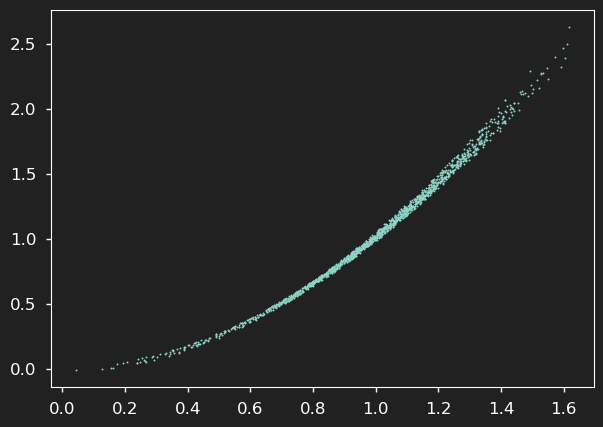

In [267]:
x, y, z = test_rec.T
r = np.sqrt(x**2 + y**2)

plt.scatter(r, z, s=1);

In [268]:
slow_map = test_ds.system.slow_map

In [269]:
slow_var = slow_map(test_data.T)

In [270]:
with torch.no_grad():
    lat_var = model.encoder(test_data).T
lat_var.shape

torch.Size([2, 1467])

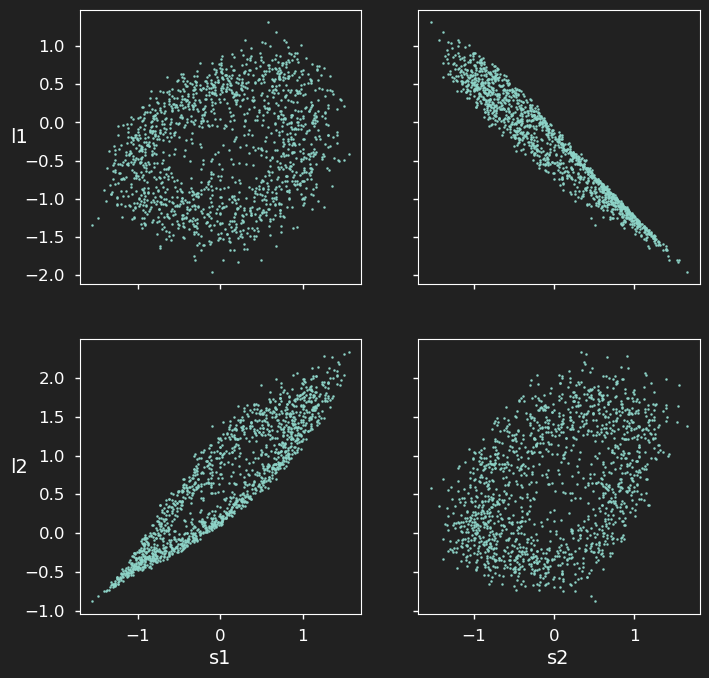

In [271]:
sdim = test_ds.system.sdim
fig, axs = plt.subplots(ncols=sdim, nrows=sdim, figsize=(8,8), sharey='row', sharex='col')
for m, slow_coord in enumerate(slow_var):
    for n, lat_coord in enumerate(lat_var):
        axs[n,m].scatter(slow_coord, lat_coord, s=2)
        if n + 1 == sdim:
            axs[n,m].set_xlabel(f"s{m+1}")
        if m == 0:
            axs[n,m].set_ylabel(f"l{n+1}", rotation=0)